In [47]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from qiskit_algorithms.optimizers import SPSA, NFT, QNSPSA

from src.Tools import portfolio_metrics
from qiskit_src.ansatz import CP_QAOA, qubo_cost
from qiskit_src.tools import get_qubo, min_cost_partition, normalized_cost

In [48]:
N=6
k=3
seed=1
alpha=0.001
layers=2
max_iter=50

w_z_phase = False
w_next_nearest_neighbors = True
w_evenly_distributed = True


In [49]:
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

max_cost, min_cost, min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
min_state_str = ''.join([str(_) for _ in min_state])
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances,
                     alpha=alpha,
                     lmbda=lmbda,
                     k=k)

In [59]:
ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 QUBO_matrix=Q,
                 QUBO_offset=offset,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_evenly_distributed_start_x=w_evenly_distributed,
                 with_z_phase=w_z_phase)

# Initial guess for parameters (gamma, beta) of circuit
theta_min, theta_max = -np.pi, np.pi
N_xx_yy_angles = layers * (N - 1) 
if w_next_nearest_neighbors:
    N_xx_yy_angles += layers * (N - 2)
if w_z_phase:
    N_xx_yy_angles += N * layers
theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_xx_yy_angles)
#theta_i = np.random.normal(loc=0, scale=1, size=N_xx_yy_angles)

_available_methods_ = ['COBYLA', 'Nelder-Mead']
_method_idx_ = 0

iteration_dicts = []

def callback_function(x):
    iteration_dicts.append(ansatz.get_state_probabilities(angles=x, flip_states=False))


res = sc.optimize.minimize(fun=ansatz.get_cost, x0=theta_i,
                           method='SLSQP',
                           options={'disp': False, 'maxiter': max_iter},
                           callback=callback_function)



"""def spsa_callback_function(n_fun_evals, params, fun_val, stepsize, flag):
    iteration_dicts.append(ansatz.get_state_probabilities(angles=params, flip_states=False))
    
def nft_callback_function(params):
    iteration_dicts.append(ansatz.get_state_probabilities(angles=params, flip_states=False))
    
spsa = QNSPSA(fidelity=ansatz.get_fidelity,maxiter=max_iter, callback=spsa_callback_function)
res = spsa.minimize(fun=ansatz.get_cost,x0=theta_i)"""

_dict_ = ansatz.get_state_probabilities(angles=res.x, flip_states=False)

res.status

0

In [58]:
res.message, res

('Optimization terminated successfully',
  message: Optimization terminated successfully
  success: True
   status: 0
      fun: -0.16470538420618897
        x: [-2.800e+00 -4.560e-01 ...  2.362e+00 -7.861e-01]
      nit: 33
      jac: [ 2.060e-05 -2.453e-05 ...  9.555e-07 -1.000e-04]
     nfev: 629
     njev: 33)

(-0.1, 1.1)

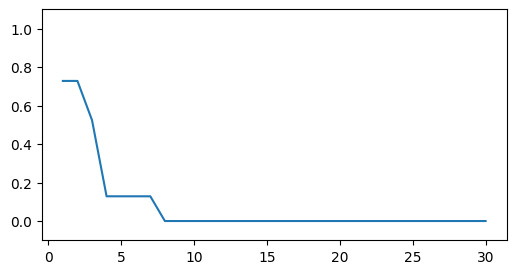

In [52]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
Y = [normalized_cost(result=it,
                 QUBO_matrix=Q,
                 QUBO_offset=offset,
                 max_cost=max_cost, 
                 min_cost=min_cost) for it in iteration_dicts]
X = [it + 1 for it in range(len(Y))]
ax.plot(X,Y)
ax.set_ylim(-0.1,1.1)


In [53]:
best_state = list(_dict_.keys())[np.argmax(list(_dict_.values()))]
best_state, _dict_[best_state] 

('110100', 0.999482896278975)

In [54]:
opt_cost = qubo_cost(min_state.astype(np.float64),Q)+offset
opt_cost

-1.412123344897749

In [55]:
found_cost = qubo_cost(np.array([float(_) for _ in best_state]).astype(np.float64), Q) + offset
found_cost 

-1.412123344897749

In [56]:
print(f'Normalized cost: {abs(found_cost - min_cost) / abs(max_cost - min_cost)}')

Normalized cost: 1.8609165701444433e-16
